In [1]:
# https://medium.com/@niveditha.itengineer/learn-how-to-setup-portaudio-and-pyaudio-in-ubuntu-to-play-with-speech-recognition-8d2fff660e94

import sounddevice as sd
import numpy as np
import scipy.signal
from scipy.special import softmax
import timeit
import python_speech_features
import os
import json
#import RPi.GPIO as GPIO
from kws_streaming.data import input_data
from kws_streaming import data
from datetime import datetime


#from tflite_runtime.interpreter import Interpreter
import tensorflow as tf


2024-02-26 21:59:09.352436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Parameters
#debug_time = 1
#debug_acc = 0
#led_pin = 8
word_threshold = 0.9

sample_rate = 16000

num_channels = 1
model_path = 'models3_30k/svdf/tflite_stream_state_external/stream_state_external.tflite'


# GPIO 
#GPIO.setwarnings(False)
#GPIO.setmode(GPIO.BOARD)
#GPIO.setup(8, GPIO.OUT, initial=GPIO.LOW)

current_dir = os.getcwd()
DATA_PATH = os.path.join(current_dir, "data2/")
MODELS_PATH = current_dir

file_name='models3_30k'
train_dir = os.path.join(MODELS_PATH, file_name, 'svdf')

current_dir

'/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming2/kws_streaming'

In [3]:
# below is another way of reading flags - through json
with tf.compat.v1.gfile.Open(os.path.join(train_dir, 'flags.json'), 'r') as fd:
   flags_json = json.load(fd)

class DictStruct(object):
   def __init__(self, **entries):
     self.__dict__.update(entries)

flags = DictStruct(**flags_json)

In [4]:
# prepare mapping of index to word
audio_processor = data.input_data.AudioProcessor(flags)
index_to_label = {}
# labels used for training
for word in audio_processor.word_to_index.keys():
  if audio_processor.word_to_index[word] == data.input_data.SILENCE_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = data.input_data.SILENCE_LABEL
  elif audio_processor.word_to_index[word] == data.input_data.UNKNOWN_WORD_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = data.input_data.UNKNOWN_WORD_LABEL
  else:
    index_to_label[audio_processor.word_to_index[word]] = word

# training labels
index_to_label

2024-02-26 21:59:12.636033: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-26 21:59:12.636921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-26 21:59:12.647387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-26 21:59:12.647490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2024-02-26 21:59:12.647502: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-26 21:59:12.649296: I tensorflow/stream_executor/platform/d

{11: 'forward',
 16: 'learn',
 10: 'follow',
 2: 'backward',
 6: 'dog',
 3: 'bed',
 5: 'cat',
 14: 'happy',
 4: 'bird',
 18: 'marvin',
 15: 'house',
 33: 'visual',
 30: 'tree',
 12: 'four',
 21: 'off',
 24: 'right',
 8: 'eight',
 17: 'left',
 22: 'on',
 27: 'six',
 13: 'go',
 23: 'one',
 7: 'down',
 19: 'nine',
 20: 'no',
 9: 'five',
 26: 'sheila',
 34: 'wow',
 32: 'up',
 25: 'seven',
 29: 'three',
 31: 'two',
 28: 'stop',
 36: 'zero',
 35: 'yes',
 0: '_silence_'}

In [5]:
# Load model (interpreter)
#interpreter = Interpreter(model_path)
interpreter = tf.lite.Interpreter(model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'input_audio', 'index': 0, 'shape': array([  1, 320], dtype=int32), 'shape_signature': array([  1, 320], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'streaming/speech_features/data_frame_1input_state', 'index': 1, 'shape': array([  1, 640], dtype=int32), 'shape_signature': array([  1, 640], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'streaming/svdf_0/depthwise_conv1d_6/depthwise_conv1d_6input_state', 'index': 2, 'shape': array([ 1,  4, 16], dtype=int32), 'shape_signature': array([ 1,  4, 16], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameter

In [6]:
inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

input_details[0]['shape']

array([  1, 320], dtype=int32)

In [7]:
# Decimate (filter and downsample)
def decimate(signal, old_fs, new_fs):
    
    # Check to make sure we're downsampling
    if new_fs > old_fs:
        print("Error: target sample rate higher than original")
        return signal, old_fs
    
    # We can only downsample by an integer factor
    dec_factor = old_fs / new_fs
    if not dec_factor.is_integer():
        print("Error: can only decimate by integer factor")
        return signal, old_fs

    # Do decimation
    resampled_signal = scipy.signal.decimate(signal, int(dec_factor))

    return resampled_signal, new_fs

In [8]:
import time as timelib



def sd_callback(rec, frames, time, status):   
    
    #global sumseconds, sumrecords
    global index, times, MAX_RECORDS, predict, probat

    if index<MAX_RECORDS-1:
        index = index+1

        #tstart = timelib.time()
        times[0, index] = timelib.time()

    # audio rec shape is : (frames, channels)
    rec = np.reshape(rec, (1,-1))

    # set input audio data (by default input data at index 0)
    interpreter.set_tensor(input_details[0]['index'], rec)

    # set input states (index 1...)
    for s in range(1, len(input_details)):
        interpreter.set_tensor(input_details[s]['index'], inputs[s])

    # run inference
    interpreter.invoke()

    # get output: classification
    out_tflite = interpreter.get_tensor(output_details[0]['index'])
    #print(start / 16000.0, np.argmax(out_tflite), np.max(out_tflite))

    # get output states and set it back to input states
    # which will be fed in the next inference cycle
    for s in range(1, len(input_details)):
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
        inputs[s] = interpreter.get_tensor(output_details[s]['index'])

    out_tflite_argmax = np.argmax(out_tflite)

    probas = softmax(out_tflite)
    proba = np.max(probas)
    if (out_tflite_argmax>1) and (proba > word_threshold):
        print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), index_to_label[out_tflite_argmax], proba)

    if index<MAX_RECORDS:
        times[1, index] = timelib.time()
        predict[index] = out_tflite_argmax
        probat[index] = proba

    


In [9]:
reset_state = True


# before processing new test sequence we can reset model state
# if we reset model state then it is not real streaming mode
if reset_state:
  for s in range(len(input_details)):
    print(input_details[s]['shape'])
    inputs[s] = np.zeros(input_details[s]['shape'], dtype=np.float32)

[  1 320]
[  1 640]
[ 1  4 16]
[ 1 10 32]
[ 1 10 32]
[ 1 10 32]
[ 1 10 64]
[  1  10 128]
[  1   1 128]


channels: 1 samplerate: 16000 blocksize: 320
26/02/2024 21:59:15 one 0.9392666
26/02/2024 21:59:16 one 0.95790064
26/02/2024 21:59:16 one 0.9584567
26/02/2024 21:59:16 one 0.96685505
26/02/2024 21:59:16 one 0.9606219
26/02/2024 21:59:16 one 0.9487183
26/02/2024 21:59:16 one 0.95745033
26/02/2024 21:59:16 one 0.95304173
26/02/2024 21:59:16 one 0.94333315
26/02/2024 21:59:16 one 0.9484628
26/02/2024 21:59:16 one 0.94925636
26/02/2024 21:59:16 one 0.95708066
26/02/2024 21:59:16 one 0.95419073
26/02/2024 21:59:16 one 0.93374175
26/02/2024 21:59:16 one 0.903112
26/02/2024 21:59:16 one 0.90049404
26/02/2024 21:59:16 one 0.90863067
26/02/2024 21:59:19 house 0.95461076
26/02/2024 21:59:19 house 0.9132244
26/02/2024 21:59:19 house 0.97497
26/02/2024 21:59:19 house 0.98229533
26/02/2024 21:59:19 house 0.9839098
26/02/2024 21:59:19 house 0.9864738
26/02/2024 21:59:19 house 0.98490494
26/02/2024 21:59:19 house 0.97457206
26/02/2024 21:59:19 house 0.9810314
26/02/2024 21:59:19 house 0.9776366
26/02

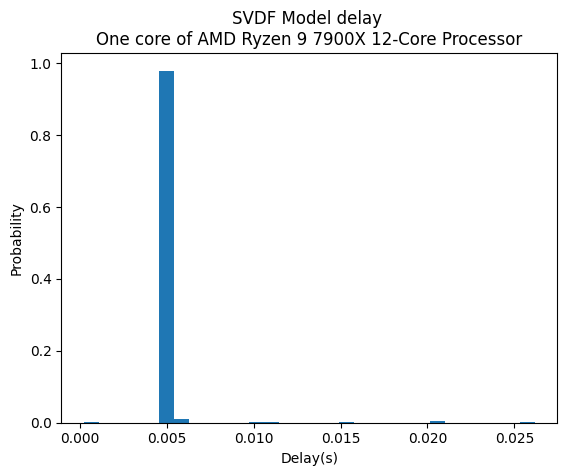


Recording finished. Nb records: 1402 std deviation: 0.0012254224901544254 average: 0.00541941381555141 CPU AMD Ryzen 9 7900X 12-Core Processor


In [10]:
# Start streaming from microphone
import matplotlib.pyplot as plt
import cpuinfo


sumseconds=0
sumrecords=0
MAX_RECORDS = 5000
index=-1
times = np.empty([2, MAX_RECORDS], dtype = float)
predict = np.empty([ MAX_RECORDS], dtype = int)
probat = np.empty([ MAX_RECORDS], dtype = float)

try:
    sumrecords=0
    print('channels:',num_channels, 'samplerate:',sample_rate, 'blocksize:', flags.window_stride_samples)
    with sd.InputStream(channels=num_channels,
                        samplerate=sample_rate,
                        blocksize=flags.window_stride_samples,
                        callback=sd_callback):
        while True:
            pass

except KeyboardInterrupt:
    times[0,:] = times[0,:] * -1
    delays = np.sum(times[:,0:index], axis=0)


    weights = np.ones_like(delays)/float(index)

    my_cpuinfo = cpuinfo.get_cpu_info()

    x, bins, p = plt.hist(delays, bins = 30, weights=weights)
    plt.ylabel('Probability')
    plt.xlabel('Delay(s)')
    plt.title(f"SVDF Model delay \nOne core of {my_cpuinfo['brand_raw']}")
    plt.show() 
    
    print('\nRecording finished. Nb records:', index, 'std deviation:', np.std(delays, axis=0), 'average:', np.mean(delays, axis=0), 'CPU', my_cpuinfo['brand_raw'])
   


except Exception as e:
    print('\nRecording finished. ')